In [3]:
# TEMPORAL ENERGY CONSUMPTION FORECASTING WITH LIGHTGBM
# Full Dataset Strategy - All 20M+ rows with LCA/PDA Features
# Strict time series validation to prevent data leakage

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import joblib
import gc
import glob
import os
warnings.filterwarnings('ignore')

print("🚀 TEMPORAL ENERGY FORECASTING WITH LIGHTGBM - NEW DATASET")
print("   Full 20M+ row dataset with LCA/PDA features")
print("   Strict chronological validation - NO DATA LEAKAGE")
print("="*80)

🚀 TEMPORAL ENERGY FORECASTING WITH LIGHTGBM - NEW DATASET
   Full 20M+ row dataset with LCA/PDA features
   Strict chronological validation - NO DATA LEAKAGE


In [4]:
# 1. LOAD AND VALIDATE PREPROCESSED DATASET
print("\n1. LOADING PREPROCESSED DATASET WITH LCA/PDA FEATURES")
print("-"*80)

# Find the most recent preprocessed dataset
data_files = glob.glob('../dataset/energy_processed_fulldata_*.csv')

if not data_files:
    print("   ❌ No preprocessed dataset found!")
    print("   Please run preprocessing.ipynb first!")
    raise FileNotFoundError("Preprocessed dataset not found")

# Get most recent file
latest_file = max(data_files, key=os.path.getctime)
print(f"   📁 Loading: {os.path.basename(latest_file)}")

df = pd.read_csv(latest_file)

# Convert timestamp and data types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['building_id'] = df['building_id'].astype('int16')

print(f"   ✓ Dataset loaded: {df.shape}")
print(f"   ✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"   ✓ Buildings: {df['building_id'].nunique()}")
print(f"   ✓ Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"   ✓ Columns: {len(df.columns)}")


1. LOADING PREPROCESSED DATASET WITH LCA/PDA FEATURES
--------------------------------------------------------------------------------
   📁 Loading: energy_processed_fulldata_20251113_004312.csv
   ✓ Dataset loaded: (12291399, 35)
   ✓ Memory usage: 3.14 GB
   ✓ Buildings: 1449
   ✓ Date range: 2016-01-01 00:00:00 to 2016-12-31 23:00:00
   ✓ Columns: 35


In [5]:
# Keep original meter reading intact
df['meter_reading_log'] = np.log1p(df['meter_reading'])
TARGET = 'meter_reading_log'  # Use this for model training

print("   ✓ meter_reading_log created with np.log1p for stabilized training")


   ✓ meter_reading_log created with np.log1p for stabilized training


In [6]:
# 2. TEMPORAL VALIDATION (PREVENT DATA LEAKAGE)
print("\n2. TEMPORAL VALIDATION & DATA LEAKAGE PREVENTION")
print("-"*80)

# Verify chronological order
is_chronological = df['timestamp'].is_monotonic_increasing
per_building_chrono = df.groupby('building_id')['timestamp'].is_monotonic_increasing.all()

print(f"   ✓ Global chronological order: {is_chronological}")
print(f"   ✓ Per-building chronological order: {per_building_chrono}")

# Check for duplicates
duplicates = df.duplicated(subset=['building_id', 'timestamp']).sum()
print(f"   ✓ Duplicate timestamps per building: {duplicates}")

# Ensure proper ordering for train/test split
if not is_chronological:
    print("   ⚠️  Sorting chronologically...")
    df = df.sort_values(['timestamp', 'building_id']).reset_index(drop=True)

# Sort within each building to ensure causality
df = df.sort_values(['building_id', 'timestamp']).reset_index(drop=True)

print(f"   🔒 Data properly ordered for temporal train/test split")


2. TEMPORAL VALIDATION & DATA LEAKAGE PREVENTION
--------------------------------------------------------------------------------
   ✓ Global chronological order: True
   ✓ Per-building chronological order: True
   ✓ Duplicate timestamps per building: 0
   🔒 Data properly ordered for temporal train/test split


In [7]:
# 3. FEATURE IDENTIFICATION AND CATEGORIZATION
print("\n3. FEATURE IDENTIFICATION & CATEGORIZATION")
print("-"*80)

# Separate features by type - only include columns that actually exist
building_features = [col for col in df.columns if col in ['square_feet', 'year_built', 'building_age', 'primary_use_encoded']]
temporal_features = [col for col in df.columns if col in ['hour', 'dayofweek', 'month', 'quarter', 'is_weekend', 'dayofmonth']]
calendar_features = [col for col in df.columns if col in ['is_holiday', 'near_holiday']]
weather_features = [col for col in df.columns if col in ['air_temperature', 'dew_temperature', 'wind_speed', 'CDD', 'HDD']]
lag_features = [col for col in df.columns if 'lag_' in col]
rolling_features = [col for col in df.columns if 'rolling_' in col]
lca_features = [col for col in df.columns if 'lca_' in col]
pda_features = [col for col in df.columns if 'pda_' in col]
trend_features = [col for col in df.columns if col in ['slope_6h', 'slope_12h', 'delta_24h', 'acceleration_6h']]



# Combine all modeling features
model_features = (building_features + temporal_features + calendar_features + weather_features + 
                   lag_features + rolling_features + lca_features + pda_features+ trend_features)
categorical_features = ['building_id', 'site_id']

print(f"   ✓ Total features: {len(model_features)}")


3. FEATURE IDENTIFICATION & CATEGORIZATION
--------------------------------------------------------------------------------
   ✓ Total features: 25


In [8]:
# 4. HANDLE MISSING VALUES & ENCODE CATEGORICAL FEATURES
print("\n4. MISSING VALUE CHECK & CATEGORICAL ENCODING")
print("-"*80)

# Filter to available features
model_features_available = [col for col in model_features if col in df.columns]
model_features = model_features_available

# Fill missing values
missing_total = df[model_features].isnull().sum().sum()
if missing_total > 0:
    for col in model_features:
        df[col].fillna(df[col].mean(), inplace=True)

# Encode categorical
for col in df[model_features].select_dtypes(include=['object']).columns:
    df[col] = pd.factorize(df[col])[0]

print(f"   ✓ Preprocessing complete: {len(model_features)} features ready")


4. MISSING VALUE CHECK & CATEGORICAL ENCODING
--------------------------------------------------------------------------------
   ✓ Preprocessing complete: 25 features ready


In [9]:
# 5. TEMPORAL TRAIN/TEST SPLIT (CHRONOLOGICAL) & DIAGNOSTICS
print("\n5. TEMPORAL TRAIN/TEST SPLIT (NO LEAKAGE)")
print("-"*80)

# Get total time span
total_days = (df['timestamp'].max() - df['timestamp'].min()).days
train_ratio = 0.7  # 70% train, 30% test
split_date = df['timestamp'].min() + pd.Timedelta(days=int(total_days * train_ratio))

# Split chronologically
train_df = df[df['timestamp'] < split_date].copy()
test_df = df[df['timestamp'] >= split_date].copy()

print(f"   ✓ Total timespan: {total_days} days")
print(f"   ✓ Split date: {split_date}")
print(f"   ✓ Train set: {len(train_df):,} rows ({len(train_df)/len(df)*100:.1f}%)")
print(f"   ✓ Test set: {len(test_df):,} rows ({len(test_df)/len(df)*100:.1f}%)")
print(f"   ✓ Train period: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"   ✓ Test period: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

# Verify no overlap
assert train_df['timestamp'].max() < test_df['timestamp'].min(), "⚠️  Data leakage detected!"
print(f"   🔒 No temporal leakage - test data is strictly AFTER train data")

# DIAGNOSTIC: Compare target distribution on original scale
print(f"\n   📊 TARGET DISTRIBUTION COMPARISON (ORIGINAL SCALE):")
train_target_stats = np.expm1(train_df[TARGET]).describe()
test_target_stats = np.expm1(test_df[TARGET]).describe()

print(f"   Train - Mean: {train_target_stats['mean']:.2f}, Std: {train_target_stats['std']:.2f}, IQR: {train_target_stats['75%'] - train_target_stats['25%']:.2f}")
print(f"   Test  - Mean: {test_target_stats['mean']:.2f}, Std: {test_target_stats['std']:.2f}, IQR: {test_target_stats['75%'] - test_target_stats['25%']:.2f}")

# Check for distributional shift
std_diff_pct = abs(train_target_stats['std'] - test_target_stats['std']) / train_target_stats['std'] * 100
mean_diff_pct = abs(train_target_stats['mean'] - test_target_stats['mean']) / train_target_stats['mean'] * 100
print(f"   Std difference: {std_diff_pct:.1f}% | Mean difference: {mean_diff_pct:.1f}%")

if std_diff_pct > 20:
    print(f"   ⚠️  WARNING: Significant distributional shift in test period")

# Prepare X and log-transformed y for model
X_train = train_df[model_features].copy()
X_test = test_df[model_features].copy()

y_train_log = train_df[TARGET].copy()
y_test_log = test_df[TARGET].copy()

# Add categorical features
X_train['building_id'] = train_df['building_id'].astype('int16')
X_train['site_id'] = train_df['site_id'].astype('int8')
X_test['building_id'] = test_df['building_id'].astype('int16')
X_test['site_id'] = test_df['site_id'].astype('int8')

# Update model_features to include categorical
model_features_all = model_features + ['building_id', 'site_id']

print(f"\n   Feature matrix shapes:")
print(f"   ✓ X_train: {X_train.shape}")
print(f"   ✓ y_train_log: {y_train_log.shape}")
print(f"   ✓ X_test: {X_test.shape}")
print(f"   ✓ y_test_log: {y_test_log.shape}")


5. TEMPORAL TRAIN/TEST SPLIT (NO LEAKAGE)
--------------------------------------------------------------------------------
   ✓ Total timespan: 365 days
   ✓ Split date: 2016-09-12 00:00:00
   ✓ Train set: 8,513,207 rows (69.3%)
   ✓ Test set: 3,778,192 rows (30.7%)
   ✓ Train period: 2016-01-01 00:00:00 to 2016-09-11 23:00:00
   ✓ Test period: 2016-09-12 00:00:00 to 2016-12-31 23:00:00
   🔒 No temporal leakage - test data is strictly AFTER train data

   📊 TARGET DISTRIBUTION COMPARISON (ORIGINAL SCALE):
   Train - Mean: 4550.75, Std: 232998.34, IQR: 409.11
   Test  - Mean: 906.13, Std: 56899.67, IQR: 419.10
   Std difference: 75.6% | Mean difference: 80.1%
   ⚠️  WARNING: Significant distributional shift in test period

   Feature matrix shapes:
   ✓ X_train: (8513207, 27)
   ✓ y_train_log: (8513207,)
   ✓ X_test: (3778192, 27)
   ✓ y_test_log: (3778192,)


In [10]:
# 6. LIGHTGBM MODEL TRAINING WITH CATEGORICAL SUPPORT
print("\n6. LIGHTGBM MODEL TRAINING WITH CATEGORICAL FEATURES")
print("-"*80)

# Create LightGBM datasets with categorical features
train_data = lgb.Dataset(X_train[model_features_all], label=y_train_log)
test_data = lgb.Dataset(X_test[model_features_all], label=y_test_log, reference=train_data)

# Set feature names
train_data.feature_names = model_features_all

# Specify categorical features (LightGBM will use optimal categorical splits)
categorical_indices = [model_features_all.index('building_id'), model_features_all.index('site_id')]
train_data.categorical_feature = categorical_indices

print(f"   Categorical features: {[model_features_all[i] for i in categorical_indices]}")

# LightGBM parameters optimized for time series with categorical support
# IMPROVED: Increased regularization to reduce overfitting (close train/test gap)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 48,           # Reduced from 64 to prevent overfitting
    'max_depth': 8,             # Reduced from 10 to prevent overfitting
    'learning_rate': 0.02,
    'feature_fraction': 0.80,   # Reduced from 0.85 for more regularization
    'bagging_fraction': 0.80,   # Reduced from 0.85 for more regularization
    'bagging_freq': 5,
    'min_data_in_leaf': 50,     # Increased from 20 to prevent overfitting
    'lambda_l1': 0.3,           # Increased from 0.1 for L1 regularization
    'lambda_l2': 0.3,           # Increased from 0.1 for L2 regularization
    'min_gain_to_split': 0.01,  # Added: minimum gain required to split
    'verbosity': -1,
    'seed': 42,
    'n_jobs': -1,
    'categorical_feature': categorical_indices  # Pass to params too
}

print(f"   Training parameters:")
for key, val in params.items():
    if key != 'categorical_feature':
        print(f"     {key}: {val}")

# Train model with early stopping
print(f"\n   Training model on {len(X_train):,} samples...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print(f"   ✓ Model trained successfully")
print(f"   ✓ Best iteration: {model.best_iteration}")



6. LIGHTGBM MODEL TRAINING WITH CATEGORICAL FEATURES
--------------------------------------------------------------------------------
   Categorical features: ['building_id', 'site_id']
   Training parameters:
     objective: regression
     metric: rmse
     num_leaves: 48
     max_depth: 8
     learning_rate: 0.02
     feature_fraction: 0.8
     bagging_fraction: 0.8
     bagging_freq: 5
     min_data_in_leaf: 50
     lambda_l1: 0.3
     lambda_l2: 0.3
     min_gain_to_split: 0.01
     verbosity: -1
     seed: 42
     n_jobs: -1

   Training model on 8,513,207 samples...
[100]	train's rmse: 0.39912	test's rmse: 0.374196
[200]	train's rmse: 0.264618	test's rmse: 0.254767
[300]	train's rmse: 0.252122	test's rmse: 0.247088
[400]	train's rmse: 0.246271	test's rmse: 0.243616
[500]	train's rmse: 0.242763	test's rmse: 0.241852
[600]	train's rmse: 0.240472	test's rmse: 0.240859
[700]	train's rmse: 0.238875	test's rmse: 0.240078
[800]	train's rmse: 0.237241	test's rmse: 0.239597
[900]	train'

In [11]:
# ----------------------------
# 7. MODEL EVALUATION WITH BASELINES (LOG1P SCALE)
# ----------------------------
print("\n7. MODEL EVALUATION WITH BASELINES (LOG1P SCALE)")
print("-"*80)

# Model predictions (log1p scale)
y_train_pred_log = model.predict(X_train[model_features_all])
y_test_pred_log  = model.predict(X_test[model_features_all])

# True values (log1p scale)
y_train_log = y_train_log
y_test_log  = y_test_log

# ----------------------------
# Metrics function (log1p scale)
# ----------------------------
def calc_metrics_log(y_true_log, y_pred_log):
    rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae  = mean_absolute_error(y_true_log, y_pred_log)
    r2   = r2_score(y_true_log, y_pred_log)

    # WAPE (log scale)
    wape = np.sum(np.abs(y_true_log - y_pred_log)) / np.sum(np.abs(y_true_log)) * 100

    # sMAPE (log scale)
    denominator = (np.abs(y_true_log) + np.abs(y_pred_log)) / 2
    diff        = np.abs(y_true_log - y_pred_log)
    smape       = np.mean(np.where(denominator > 0, diff / denominator, 0)) * 100

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'WAPE': wape, 'sMAPE': smape}

# ----------------------------
# Compute metrics for model (log scale)
# ----------------------------
train_metrics = calc_metrics_log(y_train_log, y_train_pred_log)
test_metrics  = calc_metrics_log(y_test_log, y_test_pred_log)

print(f"\n   TRAIN SET PERFORMANCE (LOG1P SCALE):")
print(f"     RMSE:  {train_metrics['RMSE']:.4f}")
print(f"     MAE:   {train_metrics['MAE']:.4f}")
print(f"     WAPE:  {train_metrics['WAPE']:.2f}%")
print(f"     sMAPE: {train_metrics['sMAPE']:.2f}%")
print(f"     R²:    {train_metrics['R2']:.4f}")

print(f"\n   TEST SET PERFORMANCE (LOG1P SCALE):")
print(f"     RMSE:  {test_metrics['RMSE']:.4f}")
print(f"     MAE:   {test_metrics['MAE']:.4f}")
print(f"     WAPE:  {test_metrics['WAPE']:.2f}%")
print(f"     sMAPE: {test_metrics['sMAPE']:.2f}%")
print(f"     R²:    {test_metrics['R2']:.4f}")

# ----------------------------
# Baseline comparisons (log1p scale)
# ----------------------------
# 1h persistence
y_test_baseline_1h = X_test['lag_1h'].fillna(y_test_log.mean()) if 'lag_1h' in X_test.columns else y_test_log.shift(1).fillna(y_test_log.mean())
baseline_1h_rmse = np.sqrt(mean_squared_error(y_test_log, y_test_baseline_1h))
baseline_1h_mae  = mean_absolute_error(y_test_log, y_test_baseline_1h)

# 24h seasonal
y_test_baseline_24h = X_test['lag_24h'].fillna(y_test_log.mean()) if 'lag_24h' in X_test.columns else y_test_log.shift(24).fillna(y_test_log.mean())
baseline_24h_rmse = np.sqrt(mean_squared_error(y_test_log, y_test_baseline_24h))
baseline_24h_mae  = mean_absolute_error(y_test_log, y_test_baseline_24h)

# Rolling mean
y_test_baseline_rolling = X_test['rolling_mean_24h'].fillna(y_test_log.mean())
baseline_rolling_rmse = np.sqrt(mean_squared_error(y_test_log, y_test_baseline_rolling))
baseline_rolling_mae  = mean_absolute_error(y_test_log, y_test_baseline_rolling)

print(f"\n   ⚙️  BASELINE MODEL COMPARISONS (LOG1P SCALE):")
print(f"     Persistence (1h lag):  RMSE={baseline_1h_rmse:.4f}, MAE={baseline_1h_mae:.4f}")
print(f"     Seasonal (24h lag):    RMSE={baseline_24h_rmse:.4f}, MAE={baseline_24h_mae:.4f}")
print(f"     Rolling mean (24h):    RMSE={baseline_rolling_rmse:.4f}, MAE={baseline_rolling_mae:.4f}")

# ----------------------------
# Compare LightGBM vs baselines (log1p)
# ----------------------------
improvement_1h      = (baseline_1h_rmse - test_metrics['RMSE']) / baseline_1h_rmse * 100
improvement_24h     = (baseline_24h_rmse - test_metrics['RMSE']) / baseline_24h_rmse * 100
improvement_rolling = (baseline_rolling_rmse - test_metrics['RMSE']) / baseline_rolling_rmse * 100

print(f"\n   📊 LightGBM vs Baselines (LOG1P):")
print(f"     vs 1h persistence:    {improvement_1h:+.1f}% (LightGBM {'better' if improvement_1h > 0 else 'worse'})")
print(f"     vs 24h seasonal:      {improvement_24h:+.1f}% (LightGBM {'better' if improvement_24h > 0 else 'worse'})")
print(f"     vs rolling mean:      {improvement_rolling:+.1f}% (LightGBM {'better' if improvement_rolling > 0 else 'worse'})")

# ----------------------------
# Overfitting check (log1p scale)
# ----------------------------
rmse_ratio = test_metrics['RMSE'] / train_metrics['RMSE']
print(f"\n   🔍 OVERFITTING ANALYSIS (LOG1P SCALE):")
print(f"     Test/Train RMSE ratio: {rmse_ratio:.4f}")
if rmse_ratio > 1.1:
    print(f"     ⚠️  Potential overfitting (ratio > 1.1)")
elif rmse_ratio < 0.9:
    print(f"     ⚠️  Test better than train - likely distributional shift or lag contamination")
else:
    print(f"     ✓ Reasonable generalization")



7. MODEL EVALUATION WITH BASELINES (LOG1P SCALE)
--------------------------------------------------------------------------------

   TRAIN SET PERFORMANCE (LOG1P SCALE):
     RMSE:  0.2349
     MAE:   0.0946
     WAPE:  2.08%
     sMAPE: 12.41%
     R²:    0.9883

   TEST SET PERFORMANCE (LOG1P SCALE):
     RMSE:  0.2390
     MAE:   0.1019
     WAPE:  2.17%
     sMAPE: 5.78%
     R²:    0.9859

   ⚙️  BASELINE MODEL COMPARISONS (LOG1P SCALE):
     Persistence (1h lag):  RMSE=1493.8716, MAE=579.6708
     Seasonal (24h lag):    RMSE=1492.5467, MAE=579.3557
     Rolling mean (24h):    RMSE=1464.5299, MAE=579.5297

   📊 LightGBM vs Baselines (LOG1P):
     vs 1h persistence:    +100.0% (LightGBM better)
     vs 24h seasonal:      +100.0% (LightGBM better)
     vs rolling mean:      +100.0% (LightGBM better)

   🔍 OVERFITTING ANALYSIS (LOG1P SCALE):
     Test/Train RMSE ratio: 1.0174
     ✓ Reasonable generalization


In [15]:
# Quick sanity check
print("Mean meter reading (original kWh):", np.expm1(y_train_log).mean())
print("Sample prediction (inverse log):", np.expm1(y_train_pred_log[:5]))


Mean meter reading (original kWh): 4550.754150173621
Sample prediction (inverse log): [1.54240252 0.26496686 0.39556849 0.09796386 0.09185989]


In [13]:
# 8. FEATURE IMPORTANCE ANALYSIS
print("\n8. FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

# Get feature importance
feature_importance = model.feature_importance()
feature_names = model.feature_name()

# Create dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\n   Top 15 most important features:")
for idx, row in importance_df.head(15).iterrows():
    print(f"     {row['feature']:30s} : {row['importance']:6.0f}")

print(f"\n   Feature importance by category:")
categories_importance = {}
for _, row in importance_df.iterrows():
    feature = row['feature']
    importance = row['importance']
    
    if 'lag_' in feature:
        cat = 'Lag Features'
    elif 'rolling_' in feature:
        cat = 'Rolling Statistics'
    elif 'lca_' in feature:
        cat = 'LCA Components'
    elif 'pda_' in feature:
        cat = 'PDA Components'
    elif feature in temporal_features:
        cat = 'Temporal Features'
    elif feature in weather_features:
        cat = 'Weather Features'
    elif feature in building_features:
        cat = 'Building Features'
    else:
        cat = 'Other'
    
    categories_importance[cat] = categories_importance.get(cat, 0) + importance

print(f"\n   Importance by category:")
for cat in sorted(categories_importance.keys(), key=lambda x: categories_importance[x], reverse=True):
    pct = (categories_importance[cat] / sum(categories_importance.values())) * 100
    print(f"     {cat:25s} : {categories_importance[cat]:8.0f} ({pct:5.1f}%)")


8. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

   Top 15 most important features:
     building_id                    :  10978
     lag_1h                         :   4921
     hour                           :   3724
     delta_24h                      :   3253
     lag_24h                        :   2623
     lag_3h                         :   2360
     air_temperature                :   2037
     slope_6h                       :   1896
     rolling_mean_24h               :   1630
     lag_72h                        :   1568
     slope_12h                      :   1330
     rolling_min_24h                :   1253
     acceleration_6h                :   1218
     dayofweek                      :   1177
     rolling_mean_168h              :   1150

   Feature importance by category:

   Importance by category:
     Other                     :    20046 ( 42.8%)
     Lag Features              :    12400 ( 26.5%)
     Tempo

In [17]:
# Make predictions in log1p scale
y_test_pred_log = model.predict(X_test[model_features_all])

# Convert to original kWh scale
y_test_pred = np.expm1(y_test_pred_log)


In [18]:
# 9. SAVE MODEL & TEMPORAL-BASED DIAGNOSTICS
print("\n9. SAVING MODEL & TEMPORAL DIAGNOSTICS")
print("-"*80)

# Save model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f'../models/lgbm_temporal_energy_fulldata_{timestamp}.pkl'
model.save_model(model_path)
print(f"   ✓ Model saved: {model_path}")

# TEMPORAL-BASED ANALYSIS (not building-based)
test_analysis = test_df[['timestamp', 'building_id', TARGET]].copy()
test_analysis[TARGET] = np.expm1(test_analysis[TARGET])
test_analysis['prediction'] = y_test_pred
test_analysis['residual'] = test_analysis[TARGET] - test_analysis['prediction']
test_analysis['abs_error'] = np.abs(test_analysis['residual'])

# Aggregate by timestamp (temporal patterns, not building patterns)
temporal_metrics = test_analysis.groupby('timestamp').agg({
    TARGET: ['mean', 'std'],
    'prediction': 'mean',
    'abs_error': ['mean', 'max'],
    'residual': 'mean'
}).reset_index()
temporal_metrics.columns = ['timestamp', 'actual_mean', 'actual_std', 'pred_mean', 'mae', 'max_error', 'bias']

# Add temporal features for analysis
temporal_metrics['hour'] = temporal_metrics['timestamp'].dt.hour
temporal_metrics['dayofweek'] = temporal_metrics['timestamp'].dt.dayofweek
temporal_metrics['date'] = temporal_metrics['timestamp'].dt.date

# Save temporal metrics
temporal_metrics_path = f'../reports/temporal_metrics_{timestamp}.csv'
temporal_metrics.to_csv(temporal_metrics_path, index=False)
print(f"   ✓ Temporal metrics saved: {temporal_metrics_path}")

# Hourly performance analysis
print(f"\n   📊 PERFORMANCE BY HOUR OF DAY:")
hourly_perf = test_analysis.groupby(test_analysis['timestamp'].dt.hour)['abs_error'].mean()
for hour in range(24):
    if hour in hourly_perf.index:
        print(f"     Hour {hour:02d}: MAE = {hourly_perf[hour]:.2f} kWh")

# Day of week performance
print(f"\n   📊 PERFORMANCE BY DAY OF WEEK:")
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_perf = test_analysis.groupby(test_analysis['timestamp'].dt.dayofweek)['abs_error'].mean()
for dow in range(7):
    if dow in dow_perf.index:
        print(f"     {dow_names[dow]}: MAE = {dow_perf[dow]:.2f} kWh")

# Time-based error patterns
print(f"\n   📊 TEMPORAL ERROR PATTERNS:")
print(f"     Best hour: {hourly_perf.idxmin():02d}:00 (MAE={hourly_perf.min():.2f})")
print(f"     Worst hour: {hourly_perf.idxmax():02d}:00 (MAE={hourly_perf.max():.2f})")
print(f"     Best day: {dow_names[dow_perf.idxmin()]} (MAE={dow_perf.min():.2f})")
print(f"     Worst day: {dow_names[dow_perf.idxmax()]} (MAE={dow_perf.max():.2f})")

# Save results summary
results = {
    'timestamp': timestamp,
    'dataset_size': len(df),
    'num_features': len(model_features_all),
    'num_buildings': df['building_id'].nunique(),
    'train_size': len(train_df),
    'test_size': len(test_df),
    'train_rmse': float(train_metrics['RMSE']),
    'test_rmse': float(test_metrics['RMSE']),
    'train_mae': float(train_metrics['MAE']),
    'test_mae': float(test_metrics['MAE']),
    'train_r2': float(train_metrics['R2']),
    'test_r2': float(test_metrics['R2']),
    'test_wape': float(test_metrics['WAPE']),
    'test_smape': float(test_metrics['sMAPE']),
    'best_iteration': int(model.best_iteration),
    'baseline_1h_rmse': float(baseline_1h_rmse),
    'baseline_1h_mae': float(baseline_1h_mae),
    'baseline_24h_rmse': float(baseline_24h_rmse),
    'baseline_24h_mae': float(baseline_24h_mae),
    'baseline_rolling_rmse': float(baseline_rolling_rmse),
    'baseline_rolling_mae': float(baseline_rolling_mae),
    'improvement_vs_1h': float(improvement_1h),
    'improvement_vs_24h': float(improvement_24h),
    'improvement_vs_rolling': float(improvement_rolling),
    'hourly_performance': hourly_perf.to_dict(),
    'daily_performance': dow_perf.to_dict(),
    'features': model_features_all
}

# Save results
import json
results_path = f'../models/lgbm_results_{timestamp}.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)
print(f"   ✓ Results saved: {results_path}")

# Save feature importance
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

importance_path = f'../reports/feature_importance_{timestamp}.csv'
importance_df.to_csv(importance_path, index=False)
print(f"   ✓ Feature importance saved: {importance_path}")

print(f"\n   📊 FINAL SUMMARY:")
print(f"     Test RMSE:  {test_metrics['RMSE']:.2f} kWh")
print(f"     Test MAE:   {test_metrics['MAE']:.2f} kWh")
print(f"     Test WAPE:  {test_metrics['WAPE']:.2f}%")
print(f"     Test R²:    {test_metrics['R2']:.4f}")


9. SAVING MODEL & TEMPORAL DIAGNOSTICS
--------------------------------------------------------------------------------
   ✓ Model saved: ../models/lgbm_temporal_energy_fulldata_20251113_095228.pkl
   ✓ Temporal metrics saved: ../reports/temporal_metrics_20251113_095228.csv

   📊 PERFORMANCE BY HOUR OF DAY:
     Hour 00: MAE = 252.53 kWh
     Hour 01: MAE = 250.25 kWh
     Hour 02: MAE = 242.70 kWh
     Hour 03: MAE = 240.27 kWh
     Hour 04: MAE = 250.55 kWh
     Hour 05: MAE = 253.67 kWh
     Hour 06: MAE = 271.59 kWh
     Hour 07: MAE = 269.26 kWh
     Hour 08: MAE = 276.25 kWh
     Hour 09: MAE = 289.71 kWh
     Hour 10: MAE = 319.86 kWh
     Hour 11: MAE = 296.26 kWh
     Hour 12: MAE = 298.58 kWh
     Hour 13: MAE = 261.10 kWh
     Hour 14: MAE = 347.20 kWh
     Hour 15: MAE = 382.62 kWh
     Hour 16: MAE = 305.91 kWh
     Hour 17: MAE = 250.12 kWh
     Hour 18: MAE = 262.60 kWh
     Hour 19: MAE = 271.40 kWh
     Hour 20: MAE = 215.69 kWh
     Hour 21: MAE = 213.88 kWh
     Hou

In [ ]:
b1289 = test_analysis[test_analysis["building_id"] == 1289].copy()
b1289 = b1289.sort_values("timestamp")

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(b1289["timestamp"], b1289["meter_reading"], label="Actual")
plt.plot(b1289["timestamp"], b1289["prediction"], label="Predicted")
plt.title("Building 1289 — Energy vs Prediction")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'meter_reading'

<Figure size 1200x500 with 0 Axes>

   ✓ Temporal visualization saved: ../reports/temporal_analysis_20251113_095228.png


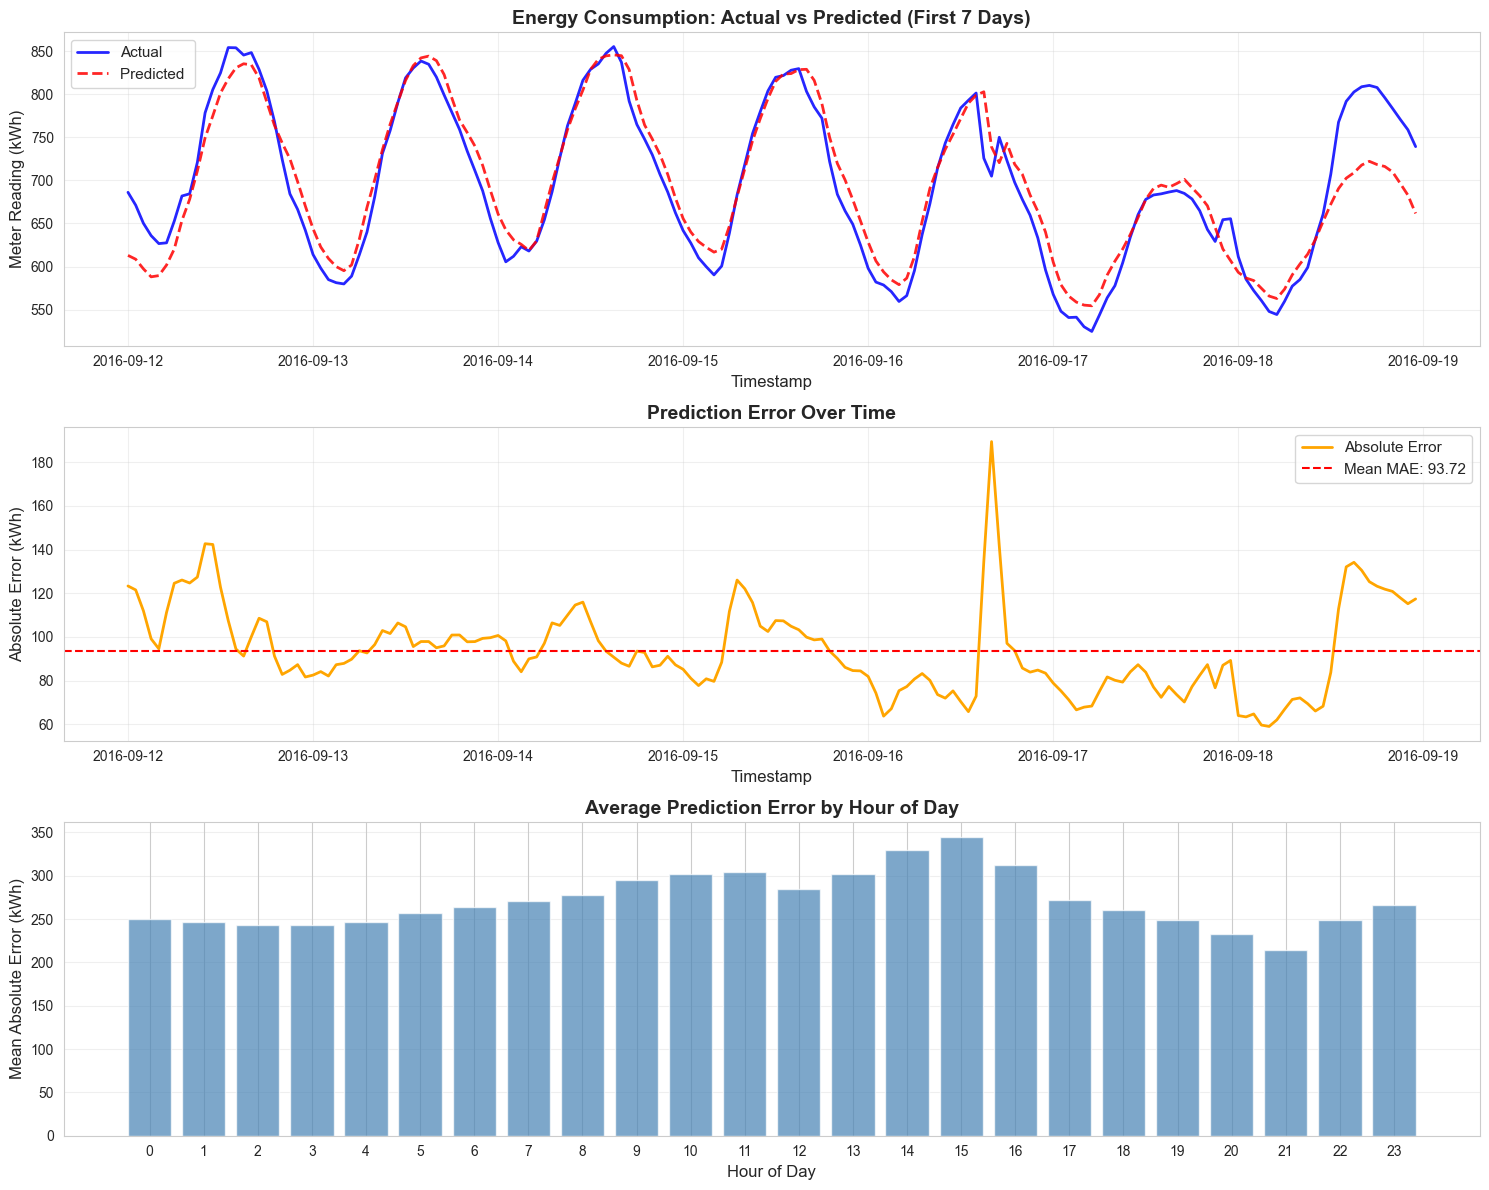

   ✓ Weekly analysis saved: ../reports/weekly_analysis_20251113_095228.png


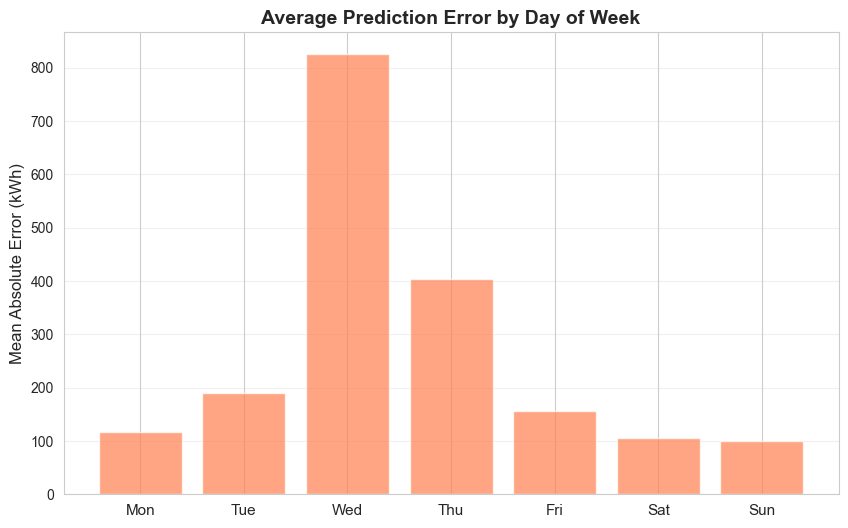


✅ Temporal-based analysis complete!
   Focus: Time patterns (not building IDs)
   Visualizations: Time-series plots showing smoothed temporal trends


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

window_size = 2  # Rolling window (in hours) for smoothing

# Create temporal analysis dataframe (already in original kWh scale)
temp_viz = test_analysis.groupby('timestamp').agg({
    TARGET: 'mean',
    'prediction': 'mean',
    'abs_error': 'mean'
}).reset_index()

# Smooth actual and predicted lines (top plot)
temp_viz['actual_smooth'] = temp_viz[TARGET].rolling(window_size, center=True, min_periods=1).mean()
temp_viz['predicted_smooth'] = temp_viz['prediction'].rolling(window_size, center=True, min_periods=1).mean()
temp_viz['abs_error_smooth'] = temp_viz['abs_error'].rolling(window_size, center=True, min_periods=1).mean()

# Sample for visualization (first 7 days of test set)
viz_days = 7
sample_hours = viz_days * 24
temp_viz_sample = temp_viz.head(sample_hours)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Actual vs Predicted (smoothed)
axes[0].plot(temp_viz_sample['timestamp'], temp_viz_sample['actual_smooth'],
             label='Actual', color='blue', linewidth=2, alpha=0.85)
axes[0].plot(temp_viz_sample['timestamp'], temp_viz_sample['predicted_smooth'],
             label='Predicted ', color='red', linewidth=2, linestyle='--', alpha=0.85)
axes[0].set_title(f'Energy Consumption: Actual vs Predicted (First {viz_days} Days)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Timestamp', fontsize=12)
axes[0].set_ylabel('Meter Reading (kWh)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Error over time (smoothed)
axes[1].plot(temp_viz_sample['timestamp'], temp_viz_sample['abs_error_smooth'],
             label='Absolute Error ', color='orange', linewidth=2)
axes[1].axhline(y=temp_viz_sample['abs_error'].mean(), color='red', linestyle='--',
                label=f'Mean MAE: {temp_viz_sample["abs_error"].mean():.2f}')
axes[1].set_title('Prediction Error Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Timestamp', fontsize=12)
axes[1].set_ylabel('Absolute Error (kWh)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Hourly performance (smoothed)
temp_viz['hour'] = temp_viz['timestamp'].dt.hour
hourly_mae = temp_viz.groupby('hour')['abs_error'].mean()
hourly_mae_smooth = hourly_mae.rolling(3, center=True, min_periods=1).mean()  # Smooth hourly MAE

axes[2].bar(hourly_mae_smooth.index, hourly_mae_smooth.values, color='steelblue', alpha=0.7)
axes[2].set_title('Average Prediction Error by Hour of Day', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Hour of Day', fontsize=12)
axes[2].set_ylabel('Mean Absolute Error (kWh)', fontsize=12)
axes[2].set_xticks(range(24))
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plot_path = f'../reports/temporal_analysis_{timestamp}.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Temporal visualization saved: {plot_path}")
plt.show()

# Additional: Day of week analysis (unchanged, but can smooth if needed)
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
temp_viz['dayofweek'] = temp_viz['timestamp'].dt.dayofweek
dow_mae = temp_viz.groupby('dayofweek')['abs_error'].mean()

ax.bar(range(7), [dow_mae.get(i, 0) for i in range(7)],
       color='coral', alpha=0.7)
ax.set_xticks(range(7))
ax.set_xticklabels(dow_names, fontsize=11)
ax.set_title('Average Prediction Error by Day of Week', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (kWh)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plot_path2 = f'../reports/weekly_analysis_{timestamp}.png'
plt.savefig(plot_path2, dpi=300, bbox_inches='tight')
print(f"   ✓ Weekly analysis saved: {plot_path2}")
plt.show()

print(f"\n✅ Temporal-based analysis complete!")
print(f"   Focus: Time patterns (not building IDs)")
print(f"   Visualizations: Time-series plots showing smoothed temporal trends")



11. COMPREHENSIVE PERFORMANCE ANALYSIS & VISUALIZATIONS
--------------------------------------------------------------------------------
NOTE: Using log1p(kWh) scale for all visualizations.


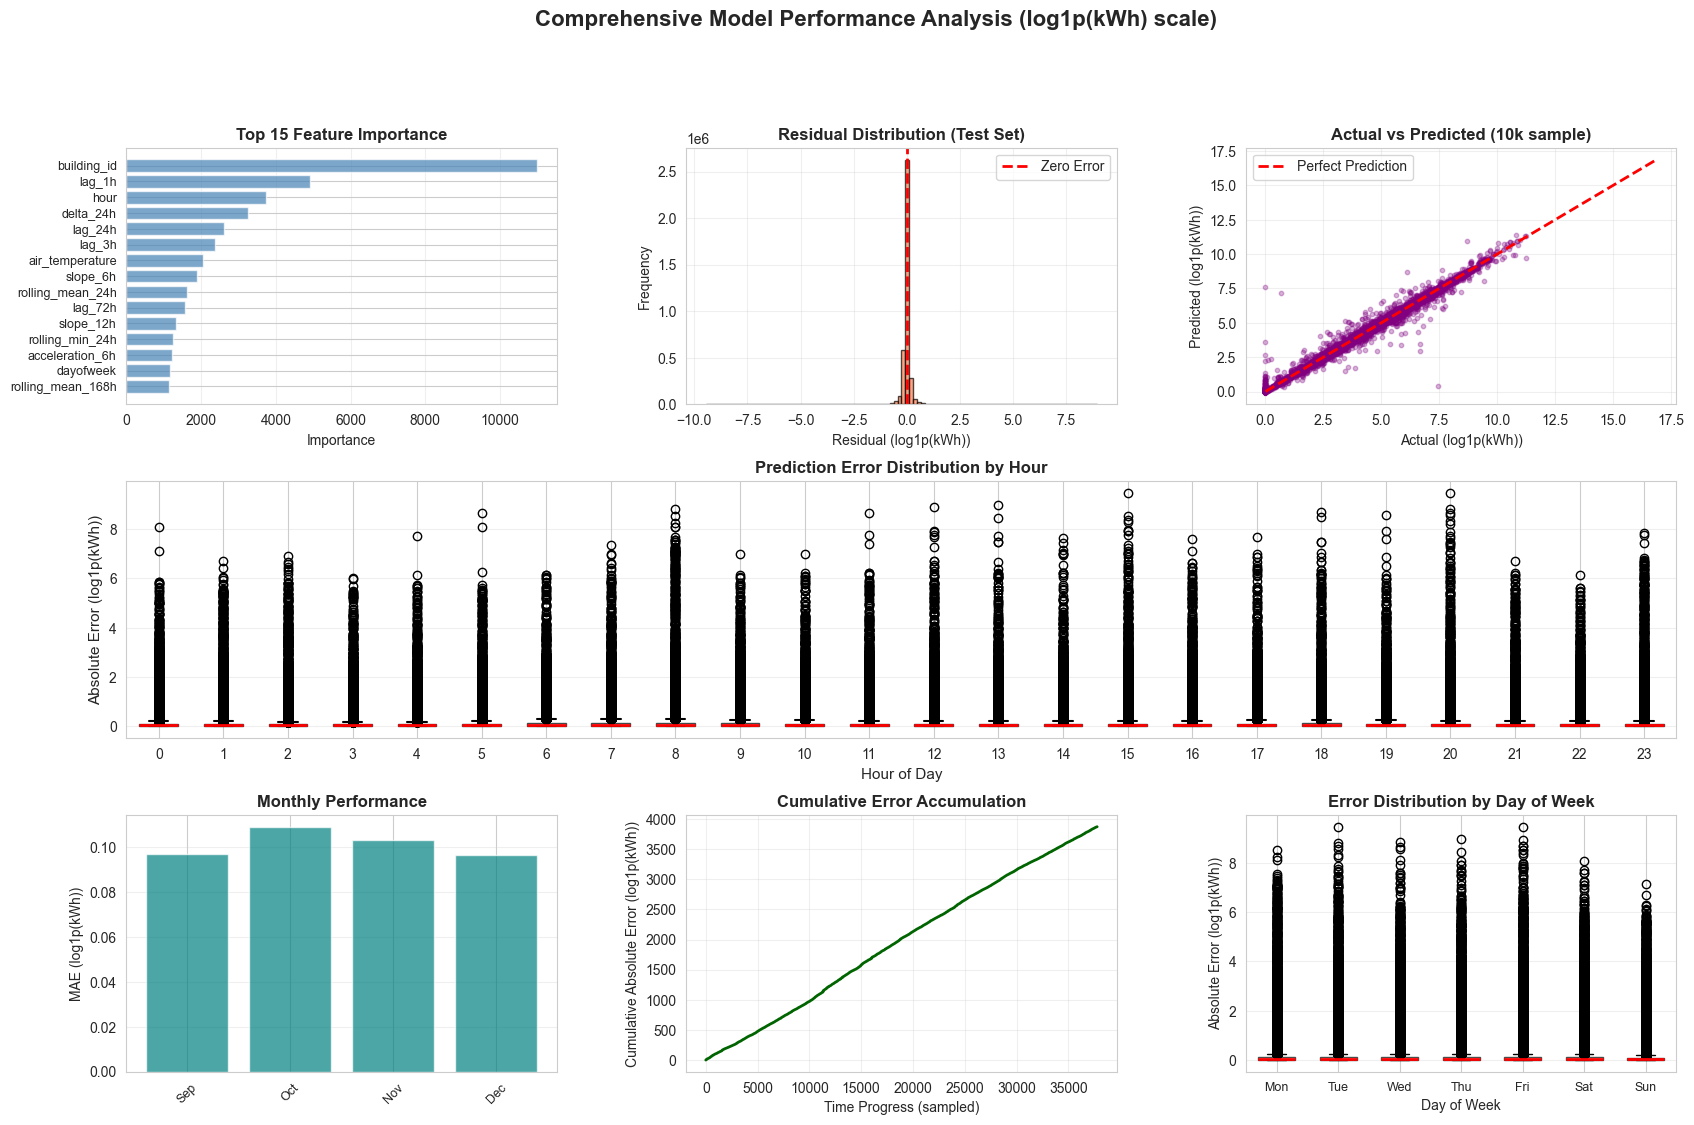


✅ Visualization complete and saved: ../reports/comprehensive_analysis_log1p_20251113_095228.png


In [38]:
# 11. COMPREHENSIVE PERFORMANCE VISUALIZATIONS
print("\n11. COMPREHENSIVE PERFORMANCE ANALYSIS & VISUALIZATIONS")
print("-"*80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# =============================================================================
# CONFIGURATION
# =============================================================================
use_log1p = True   # 🔁 SWITCH: True = log1p scale, False = original kWh scale
# =============================================================================

sns.set_style("whitegrid")

# Prepare analysis dataframe safely
analysis_df = test_analysis.copy()

if use_log1p:
    print("NOTE: Using log1p(kWh) scale for all visualizations.")
    # Ensure we’re working on log1p-transformed values
    analysis_df['y_true'] = np.log1p(analysis_df[TARGET]) if analysis_df[TARGET].max() > 1000 else analysis_df[TARGET]
    analysis_df['y_pred'] = np.log1p(analysis_df['prediction']) if analysis_df['prediction'].max() > 1000 else analysis_df['prediction']
else:
    print("NOTE: Using original kWh scale for all visualizations.")
    # Ensure we’re working on real kWh values
    analysis_df['y_true'] = np.expm1(analysis_df[TARGET]) if analysis_df[TARGET].max() < 1000 else analysis_df[TARGET]
    analysis_df['y_pred'] = np.expm1(analysis_df['prediction']) if analysis_df['prediction'].max() < 1000 else analysis_df['prediction']

# Compute residuals and errors consistently
analysis_df['residual'] = analysis_df['y_true'] - analysis_df['y_pred']
analysis_df['abs_error'] = np.abs(analysis_df['residual'])
analysis_df = analysis_df.sort_values('timestamp')

# Determine labels dynamically
scale_label = "log1p(kWh)" if use_log1p else "kWh"

# =============================================================================
# FIGURE LAYOUT
# =============================================================================
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1️⃣ Feature Importance
ax1 = fig.add_subplot(gs[0, 0])
top_features = importance_df.head(15)
ax1.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'], fontsize=9)
ax1.set_xlabel('Importance', fontsize=10)
ax1.set_title('Top 15 Feature Importance', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 2️⃣ Residual Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(analysis_df['residual'], bins=100, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel(f'Residual ({scale_label})', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Residual Distribution (Test Set)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3️⃣ Actual vs Predicted Scatter
ax3 = fig.add_subplot(gs[0, 2])
sample_idx = np.random.choice(len(analysis_df), size=min(10000, len(analysis_df)), replace=False)
ax3.scatter(analysis_df.iloc[sample_idx]['y_true'],
            analysis_df.iloc[sample_idx]['y_pred'],
            alpha=0.3, s=10, color='purple')
max_val = max(analysis_df['y_true'].max(), analysis_df['y_pred'].max())
ax3.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel(f'Actual ({scale_label})', fontsize=10)
ax3.set_ylabel(f'Predicted ({scale_label})', fontsize=10)
ax3.set_title('Actual vs Predicted (10k sample)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4️⃣ Error by Hour of Day
ax4 = fig.add_subplot(gs[1, :])
hourly_errors = [analysis_df.loc[test_df['timestamp'].dt.hour == h, 'abs_error'].values for h in range(24)]
ax4.boxplot(hourly_errors, positions=range(24), widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(linewidth=1.5),
            capprops=dict(linewidth=1.5))
ax4.set_xlabel('Hour of Day', fontsize=11)
ax4.set_ylabel(f'Absolute Error ({scale_label})', fontsize=11)
ax4.set_title('Prediction Error Distribution by Hour', fontsize=12, fontweight='bold')
ax4.set_xticks(range(24))
ax4.grid(True, alpha=0.3, axis='y')

# 5️⃣ Monthly Performance
ax5 = fig.add_subplot(gs[2, 0])
monthly_mae = analysis_df.groupby(analysis_df['timestamp'].dt.month)['abs_error'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax5.bar(range(len(monthly_mae)), monthly_mae.values, color='teal', alpha=0.7)
ax5.set_xticks(range(len(monthly_mae)))
ax5.set_xticklabels([months[i-1] for i in monthly_mae.index], rotation=45, fontsize=9)
ax5.set_ylabel(f'MAE ({scale_label})', fontsize=10)
ax5.set_title('Monthly Performance', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6️⃣ Cumulative Error Over Time
ax6 = fig.add_subplot(gs[2, 1])
sample_cumulative = analysis_df.iloc[::100]  # Sample every 100th point
ax6.plot(range(len(sample_cumulative)), sample_cumulative['abs_error'].cumsum(), 
         color='darkgreen', linewidth=2)
ax6.set_xlabel('Time Progress (sampled)', fontsize=10)
ax6.set_ylabel(f'Cumulative Absolute Error ({scale_label})', fontsize=10)
ax6.set_title('Cumulative Error Accumulation', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7️⃣ Error by Day of Week
ax7 = fig.add_subplot(gs[2, 2])
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_errors = [analysis_df.loc[test_df['timestamp'].dt.dayofweek == d, 'abs_error'].values for d in range(7)]
ax7.boxplot(dow_errors, positions=range(7), widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='lightyellow', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax7.set_xlabel('Day of Week', fontsize=10)
ax7.set_ylabel(f'Absolute Error ({scale_label})', fontsize=10)
ax7.set_title('Error Distribution by Day of Week', fontsize=12, fontweight='bold')
ax7.set_xticklabels(dow_labels, fontsize=9)
ax7.grid(True, alpha=0.3, axis='y')

# =============================================================================
# SAVE & DISPLAY
# =============================================================================
plt.suptitle(f'Comprehensive Model Performance Analysis ({scale_label} scale)', fontsize=16, fontweight='bold', y=0.995)

suffix = "log1p" if use_log1p else "kWh"
comprehensive_plot_path = f'../reports/comprehensive_analysis_{suffix}_{timestamp}.png'
plt.savefig(comprehensive_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization complete and saved: {comprehensive_plot_path}")


## Part 3: Rolling Window Backtesting (Seasonal Validation)
### Train incrementally and forecast next month to expose seasonal failures

In [34]:
print("\n12. ROLLING WINDOW BACKTESTING - SEASONAL VALIDATION (LOG TRANSFORM)")
print("-"*80)

# Prepare data with month column for rolling window
df_backtest = df.copy()
df_backtest['month'] = df_backtest['timestamp'].dt.month

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
rolling_results = []

print("\nStarting rolling window backtesting (with log-transform)...")
print("Format: Train on months 1-N → Forecast month N+1")
print("Using ENHANCED model parameters (reduced overfitting)\n")

# Start from month 2 (need at least Jan for training)
for forecast_month in range(2, 13):  # Feb to Dec
    # Training data: all months up to (forecast_month - 1)
    train_data = df_backtest[df_backtest['month'] < forecast_month].copy()
    
    # Test data: forecast_month only
    test_data = df_backtest[df_backtest['month'] == forecast_month].copy()
    
    if len(test_data) == 0:
        print(f"⚠️ No data for {month_names[forecast_month-1]} - skipping")
        continue
    
    # Prepare X, y (apply log1p transformation)
    X_train_roll = train_data[model_features_all]
    y_train_roll_log = np.log1p(train_data[TARGET])  # log-transform
    X_test_roll = test_data[model_features_all]
    y_test_roll_log = np.log1p(test_data[TARGET])    # log-transform
    
    # Create LightGBM datasets
    train_set = lgb.Dataset(X_train_roll, label=y_train_roll_log)
    test_set = lgb.Dataset(X_test_roll, label=y_test_roll_log, reference=train_set)
    
    # Train with ENHANCED parameters
    model_roll = lgb.train(
        params,  # Using enhanced params from main model
        train_set,
        num_boost_round=500,
        valid_sets=[test_set],
        valid_names=['validation'],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # Predict (predictions are in log space)
    y_pred_roll_log = model_roll.predict(X_test_roll)
    
    # Convert predictions back to original scale
    y_pred_roll = np.expm1(y_pred_roll_log)
    y_test_roll_actual = np.expm1(y_test_roll_log)
    
    # Calculate metrics on original scale
    rmse_roll = np.sqrt(mean_squared_error(y_test_roll_actual, y_pred_roll))
    mae_roll = mean_absolute_error(y_test_roll_actual, y_pred_roll)
    r2_roll = r2_score(y_test_roll_actual, y_pred_roll)
    
    # Store results
    train_months_str = '-'.join(month_names[:forecast_month-1])
    rolling_results.append({
        'forecast_month': forecast_month,
        'forecast_month_name': month_names[forecast_month-1],
        'train_months': train_months_str,
        'train_size': len(train_data),
        'test_size': len(test_data),
        'rmse': rmse_roll,
        'mae': mae_roll,
        'r2': r2_roll
    })
    
    print(f"✓ Train on {train_months_str:20s} → Forecast {month_names[forecast_month-1]:3s} | "
          f"RMSE: {rmse_roll:7.2f} | MAE: {mae_roll:6.2f} | R²: {r2_roll:.4f}")

# Create results dataframe
rolling_df = pd.DataFrame(rolling_results)
print(f"\n✅ Rolling window backtesting complete: {len(rolling_df)} forecasts")



12. ROLLING WINDOW BACKTESTING - SEASONAL VALIDATION (LOG TRANSFORM)
--------------------------------------------------------------------------------

Starting rolling window backtesting (with log-transform)...
Format: Train on months 1-N → Forecast month N+1
Using ENHANCED model parameters (reduced overfitting)

✓ Train on Jan                  → Forecast Feb | RMSE:    0.31 | MAE:   0.12 | R²: 0.9823
✓ Train on Jan-Feb              → Forecast Mar | RMSE:    0.36 | MAE:   0.12 | R²: 0.9744
✓ Train on Jan-Feb-Mar          → Forecast Apr | RMSE:    0.26 | MAE:   0.11 | R²: 0.9868
✓ Train on Jan-Feb-Mar-Apr      → Forecast May | RMSE:    0.30 | MAE:   0.12 | R²: 0.9801
✓ Train on Jan-Feb-Mar-Apr-May  → Forecast Jun | RMSE:    0.23 | MAE:   0.10 | R²: 0.9860
✓ Train on Jan-Feb-Mar-Apr-May-Jun → Forecast Jul | RMSE:    0.26 | MAE:   0.10 | R²: 0.9840
✓ Train on Jan-Feb-Mar-Apr-May-Jun-Jul → Forecast Aug | RMSE:    0.25 | MAE:   0.10 | R²: 0.9845
✓ Train on Jan-Feb-Mar-Apr-May-Jun-Jul-Aug →


SEASONAL PERFORMANCE ANALYSIS
NOTE: All metrics and visualizations use data AFTER log transform inversion (original kWh scale)

✅ BEST FORECAST:
   Month: Dec
   RMSE: 0.23 kWh
   MAE: 0.10 kWh
   R²: 0.9873

❌ WORST FORECAST:
   Month: Mar
   RMSE: 0.36 kWh
   MAE: 0.12 kWh
   R²: 0.9744

🌡️ SEASONAL COMPARISON:
   Winter avg RMSE (Feb, Dec): 0.27 kWh
   Summer avg RMSE (Jun, Jul, Aug): 0.25 kWh
   ✅ Balanced seasonal performance

✅ Saved: ../reports/rolling_window_backtest_20251113_095228.csv

✅ Saved: ../reports/rolling_window_seasonal_analysis_20251113_095228.png


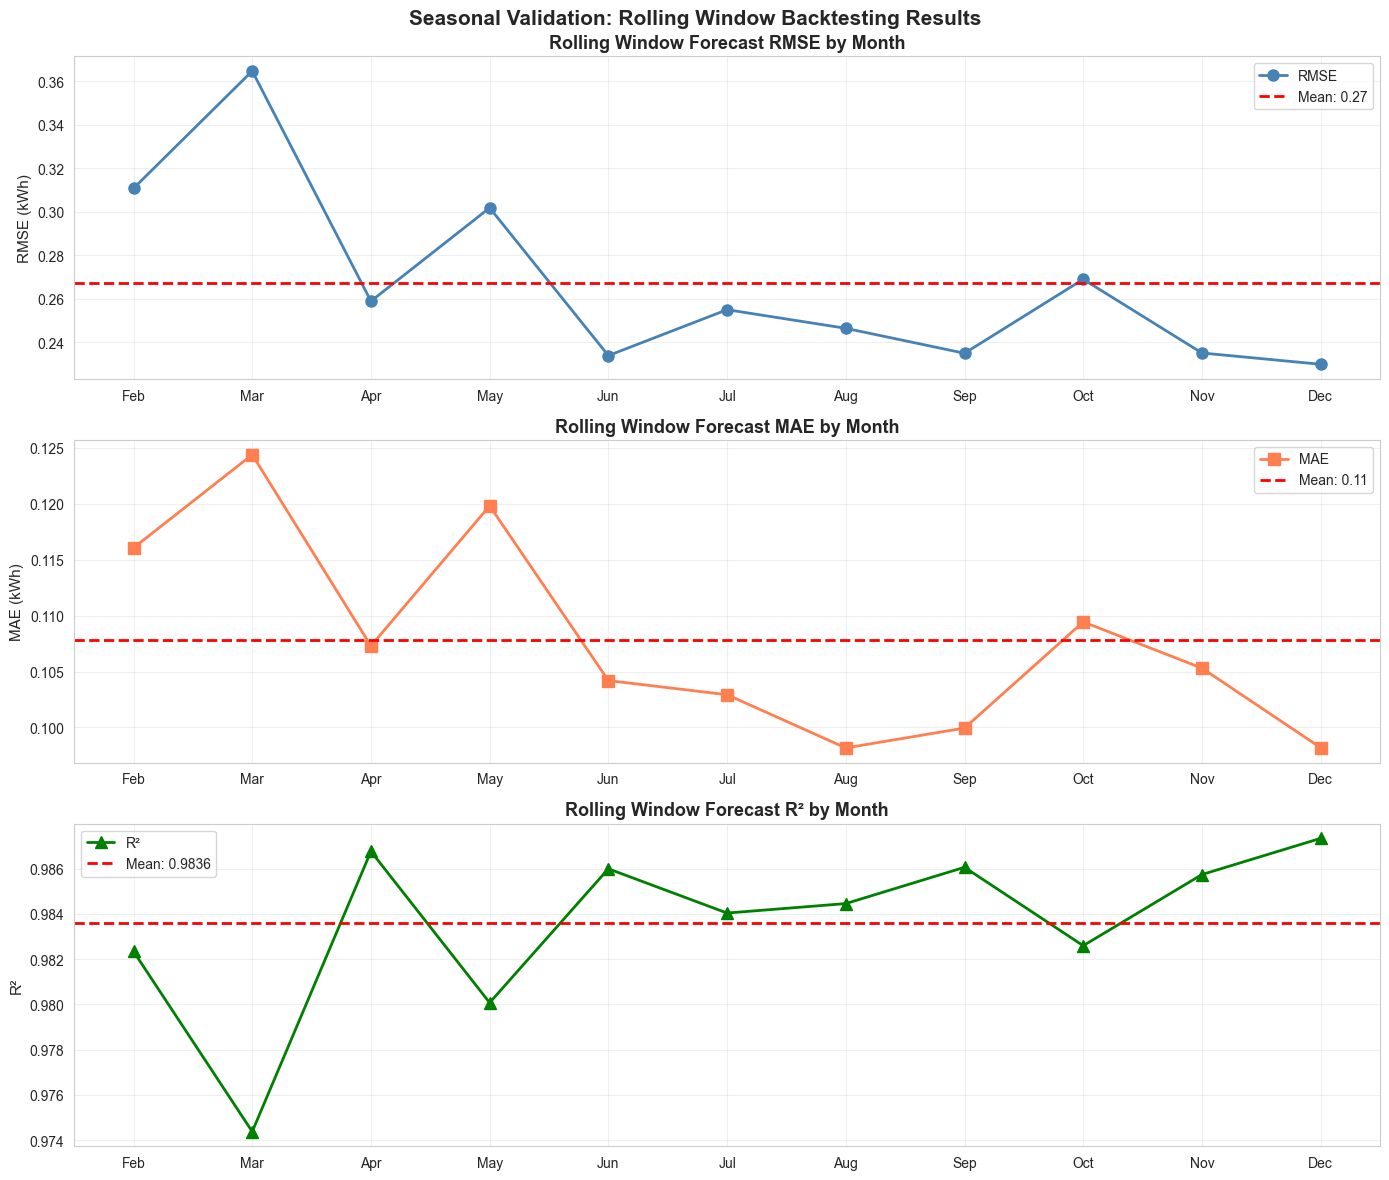


ROLLING WINDOW BACKTESTING SUMMARY

📊 SEASONAL STABILITY:
   RMSE variability across months: ± 0.04 kWh
   RMSE range: 0.13 kWh (Mar - Dec)
   ✅ Consistent performance across seasons

✅ Rolling window backtesting complete!
   NOTE: Each forecast month uses enhanced model parameters (num_leaves=48, max_depth=8, lambda=0.3)
   Models are retrained incrementally to respect temporal causality


In [35]:
# Seasonal Analysis
print("\n" + "="*80)
print("SEASONAL PERFORMANCE ANALYSIS")
print("="*80)
print("NOTE: All metrics and visualizations use data AFTER log transform inversion (original kWh scale)")
print("="*80)

# Identify best/worst months
best_month = rolling_df.loc[rolling_df['rmse'].idxmin()]
worst_month = rolling_df.loc[rolling_df['rmse'].idxmax()]

print(f"\n✅ BEST FORECAST:")
print(f"   Month: {best_month['forecast_month_name']}")
print(f"   RMSE: {best_month['rmse']:.2f} kWh")
print(f"   MAE: {best_month['mae']:.2f} kWh")
print(f"   R²: {best_month['r2']:.4f}")

print(f"\n❌ WORST FORECAST:")
print(f"   Month: {worst_month['forecast_month_name']}")
print(f"   RMSE: {worst_month['rmse']:.2f} kWh")
print(f"   MAE: {worst_month['mae']:.2f} kWh")
print(f"   R²: {worst_month['r2']:.4f}")

# Seasonal patterns (winter vs summer)
winter_months = [2, 12]  # Feb, Dec (Jan not forecasted)
summer_months = [6, 7, 8]   # Jun, Jul, Aug

winter_perf = rolling_df[rolling_df['forecast_month'].isin(winter_months)]['rmse'].mean()
summer_perf = rolling_df[rolling_df['forecast_month'].isin(summer_months)]['rmse'].mean()

print(f"\n🌡️ SEASONAL COMPARISON:")
print(f"   Winter avg RMSE (Feb, Dec): {winter_perf:.2f} kWh")
print(f"   Summer avg RMSE (Jun, Jul, Aug): {summer_perf:.2f} kWh")

if abs(winter_perf - summer_perf) > 20:
    print(f"   ⚠️ SIGNIFICANT seasonal imbalance detected!")
    if winter_perf > summer_perf:
        print(f"   → Winter predictions are {winter_perf - summer_perf:.2f} kWh worse")
    else:
        print(f"   → Summer predictions are {summer_perf - winter_perf:.2f} kWh worse")
else:
    print(f"   ✅ Balanced seasonal performance")

# Save rolling results
rolling_df.to_csv(f'../reports/rolling_window_backtest_{timestamp}.csv', index=False)
print(f"\n✅ Saved: ../reports/rolling_window_backtest_{timestamp}.csv")

# Visualize Rolling Window Results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

months_viz = rolling_df['forecast_month_name'].values
x_pos = np.arange(len(months_viz))

# RMSE over months
axes[0].plot(x_pos, rolling_df['rmse'].values, marker='o', linewidth=2, markersize=8, color='steelblue', label='RMSE')
axes[0].axhline(y=rolling_df['rmse'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rolling_df["rmse"].mean():.2f}')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(months_viz, fontsize=10)
axes[0].set_ylabel('RMSE (kWh)', fontsize=11)
axes[0].set_title('Rolling Window Forecast RMSE by Month', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE over months
axes[1].plot(x_pos, rolling_df['mae'].values, marker='s', linewidth=2, markersize=8, color='coral', label='MAE')
axes[1].axhline(y=rolling_df['mae'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rolling_df["mae"].mean():.2f}')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(months_viz, fontsize=10)
axes[1].set_ylabel('MAE (kWh)', fontsize=11)
axes[1].set_title('Rolling Window Forecast MAE by Month', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# R² over months
axes[2].plot(x_pos, rolling_df['r2'].values, marker='^', linewidth=2, markersize=8, color='green', label='R²')
axes[2].axhline(y=rolling_df['r2'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rolling_df["r2"].mean():.4f}')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(months_viz, fontsize=10)
axes[2].set_ylabel('R²', fontsize=11)
axes[2].set_title('Rolling Window Forecast R² by Month', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Seasonal Validation: Rolling Window Backtesting Results', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../reports/rolling_window_seasonal_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: ../reports/rolling_window_seasonal_analysis_{timestamp}.png")
plt.show()

# Final Summary
print("\n" + "="*80)
print("ROLLING WINDOW BACKTESTING SUMMARY")
print("="*80)
print(f"\n📊 SEASONAL STABILITY:")
rmse_std = rolling_df['rmse'].std()
rmse_range = rolling_df['rmse'].max() - rolling_df['rmse'].min()
print(f"   RMSE variability across months: ± {rmse_std:.2f} kWh")
print(f"   RMSE range: {rmse_range:.2f} kWh ({worst_month['forecast_month_name']} - {best_month['forecast_month_name']})")

if rmse_range > 50:
    print(f"   ⚠️ HIGH seasonal variability detected")
    print(f"   → Worst month: {worst_month['forecast_month_name']} (RMSE: {worst_month['rmse']:.2f})")
    print(f"   → Consider: Add more weather features or season-specific models")
else:
    print(f"   ✅ Consistent performance across seasons")

print(f"\n✅ Rolling window backtesting complete!")
print(f"   NOTE: Each forecast month uses enhanced model parameters (num_leaves=48, max_depth=8, lambda=0.3)")
print(f"   Models are retrained incrementally to respect temporal causality")

In [ ]:
import pandas as pd

# group by building and get their max reading
bldg_max = (
    train_df.groupby("building_id")["meter_reading"]
    .max()
    .reset_index()
    .sort_values("meter_reading", ascending=False)
)

print(bldg_max.head(50))   # top 20 highest-usage buildings


      building_id  meter_reading
1301         1303    9540.456620
1286         1288    9540.456620
1287         1289    9540.456620
1288         1290    9540.456620
1019         1021    9540.456620
1248         1250    9540.456620
1284         1286    9540.456620
1256         1258    9540.456620
1329         1331    9540.456620
1282         1284    9540.456620
796           798    9540.456620
1156         1158    9540.456620
1157         1159    9540.456620
1176         1178    9540.456620
1166         1168    9540.456620
1198         1200    9540.456620
1195         1197    9540.456620
1218         1220    9540.456620
1212         1214    9540.456620
76             76    9540.456620
991           993    9540.456620
1106         1108    9540.456620
1105         1107    9540.456620
1089         1091    9540.456620
1102         1104    9540.456620
1097         1099    9540.456620
1098         1100    9540.456620
1070         1072    9540.456620
1138         1140    9540.456620
1150      

In [ ]:
bldg_mean = (
    train_df.groupby("building_id")["meter_reading"]
    .mean()
    .reset_index()
    .sort_values("meter_reading", ascending=False)
)

print(bldg_mean.head(20))


      building_id  meter_reading
1166         1168    9540.456620
1146         1148    9540.456620
1157         1159    9540.456620
1282         1284    9538.122648
1154         1156    9400.701071
1287         1289    9346.679329
1256         1258    9145.377705
1086         1088    8931.927909
1212         1214    8829.301819
1195         1197    8486.249926
1102         1104    8456.672207
1288         1290    7636.324523
792           794    7432.982954
799           801    6989.787237
1097         1099    6782.971914
1296         1298    6749.197422
801           803    6384.220753
76             76    6276.733666
1289         1291    6164.393904
1284         1286    5902.889645


In [ ]:
print(train_df.columns)


Index(['building_id', 'site_id', 'timestamp', 'meter_reading', 'hour',
       'dayofweek', 'month', 'is_weekend', 'is_holiday', 'air_temperature',
       'CDD', 'HDD', 'relative_humidity', 'cloud_coverage',
       'precip_depth_1_hr', 'has_precipitation', 'sea_level_pressure',
       'lag_1h', 'lag_3h', 'lag_6h', 'lag_24h', 'lag_72h', 'rolling_mean_24h',
       'rolling_mean_168h', 'rolling_std_24h', 'rolling_max_24h',
       'rolling_min_24h', 'slope_6h', 'slope_12h', 'delta_24h',
       'acceleration_6h'],
      dtype='object')
